In [2]:
import json

from es_client import ElasticClient
from download import download
import pandas as pd
import xgboost as xgb
from matplotlib.pylab import rcParams

# import ltr
# import ltr.client as client
# import ltr.index as index
# import ltr.helpers.movies as helpers

from judgement import Judgment, judgments_to_file, judgments_to_dataframe, judgments_from_file


rcParams['figure.figsize'] = 50,150

In [3]:
corpus = 'http://es-learn-to-rank.labs.o19s.com/tmdb.json'
download([corpus], dest='data/')

data/tmdb.json already exists


In [4]:
client = ElasticClient()

In [5]:
class Memoize:
    """ Adapted from
        https://stackoverflow.com/questions/1988804/what-is-memoization-and-how-can-i-use-it-in-python"""
    def __init__(self, f):
        self.f = f
        self.memo = {}
    def __call__(self, *args):
        if not args in self.memo:
            self.memo[args] = self.f(*args)
        #Warning: You may wish to do a deepcopy here if returning objects
        return self.memo[args]

@Memoize
def load_movies(json_path):
    return json.load(open(json_path))

def get_movie(tmdb_id, movies='data/tmdb.json'):
    movies = load_movies(movies)
    tmdb_id=str(tmdb_id)
    return movies[tmdb_id]

def noop(src_movie, base_doc):
    return base_doc


def indexable_movies(enrich=noop, movies='data/tmdb.json'):
    """ Generates TMDB movies, similar to how ES Bulk indexing
    uses a generator to generate bulk index/update actions"""
    movies = load_movies(movies)
    idx = 0
    for movieId, tmdbMovie in movies.items():
        try:
            releaseDate = None
            if 'release_date' in tmdbMovie and len(tmdbMovie['release_date']) > 0:
                releaseDate = tmdbMovie['release_date']
                releaseYear = releaseDate[0:4]

            full_poster_path = ''
            if 'poster_path' in tmdbMovie and tmdbMovie['poster_path'] is not None and len(tmdbMovie['poster_path']) > 0:
                full_poster_path = 'https://image.tmdb.org/t/p/w185' + tmdbMovie['poster_path']

            base_doc = {'id': movieId,
                        'title': tmdbMovie['title'],
                        'overview': tmdbMovie['overview'],
                        'tagline': tmdbMovie['tagline'],
                        'directors': [director['name'] for director in tmdbMovie['directors']],
                        'cast': " ".join([castMember['name'] for castMember in tmdbMovie['cast']]),
                        'genres': [genre['name'] for genre in tmdbMovie['genres']],
                        'release_date': releaseDate,
                        'release_year': releaseYear,
                        'poster_path': full_poster_path,
                        'vote_average': float(tmdbMovie['vote_average']) if 'vote_average' in tmdbMovie else None,
                        'vote_count': int(tmdbMovie['vote_count']) if 'vote_count' in tmdbMovie else 0,
                      }
            yield enrich(tmdbMovie, base_doc)
            idx += 1
        except KeyError as k: # Ignore any movies missing these attributes
            continue

In [6]:
def rebuild(client, index, doc_src, force = False):
    """ Reload a configuration on disk for each search engine
        (Solr a configset, Elasticsearch a json file)
        and reindex
    """

    if client.check_index_exists(index):
        if (force):
            client.delete_index(index)
            client.create_index(index)
            client.index_documents(index, doc_src=doc_src)
        else:
            print("Index {} already exists. Use `force = True` to delete and recreate".format(index))
            return None
    else:
        client.create_index(index)
        client.index_documents(index, doc_src=doc_src)

In [7]:
movies = indexable_movies(movies='data/tmdb.json')
rebuild(client, index='tmdb', doc_src=movies)

/Users/hiromu.nakamura/ghq/github.com/po3rin/python_playground/.venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.16/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


Created index tmdb [Status: 200]
Streaming Bulk index DONE tmdb [Status: 201]


In [8]:
# wipes out any existing LTR models/feature sets in the tmdb index
client.reset_ltr(index='tmdb')

Removed Default LTR feature store [Status: 404]
Initialize Default LTR feature store [Status: 200]


In [9]:
feature_set = {
    "featureset": {
        "features": [
            {
                "name": "release_year",
                "params": [],
                "template": {
                    "function_score": {
                        "field_value_factor": {
                            "field": "release_year",
                            "missing": 2000
                        },
                        "query": { "match_all": {} }
                    }
                }
            }
        ]
    }
}

feature_set

{'featureset': {'features': [{'name': 'release_year',
    'params': [],
    'template': {'function_score': {'field_value_factor': {'field': 'release_year',
       'missing': 2000},
      'query': {'match_all': {}}}}}]}}

In [10]:
# pushes the feature set to the tmdb index's LTR store (a hidden index)
client.create_featureset(index='tmdb', name='release', ftr_config=feature_set)

Create release feature set [Status: 201]


実際のトレーニングセットを使用する前に、モデルの2つの例を試してみます。常に新しい映画を好むもの。そして、常に古い映画を好む別のもの。興味がある場合は、これを実行した後にclassic-training.txtとlatest-training.txtを操作して、トレーニングセットがどのように見えるかを確認できます。

In [11]:
def get_classic_rating(year):
    if year > 2010:
        return 0
    elif year > 1990:
        return 1
    elif year > 1970:
        return 2
    elif year > 1950:
        return 3
    else:
        return 4

def get_latest_rating(year):
    if year > 2010:
        return 4
    elif year > 1990:
        return 3
    elif year > 1970:
        return 2
    elif year > 1950:
        return 1
    else:
        return 0

def synthesize(
    client,
    featureSet='release',
    latestTrainingSetOut='data/latest-training.txt',
    classicTrainingSetOut='data/classic-training.txt'
):
    NO_ZERO = False

    resp = client.log_query('tmdb', 'release', None)

    # A classic film fan
    judgments = []
    print("Generating 'classic' biased judgments:")
    for hit in resp:
        rating = get_classic_rating(hit['ltr_features'][0])

        if rating == 0 and NO_ZERO:
            continue

        judgments.append(Judgment(qid=1,docId=hit['id'],grade=rating,features=hit['ltr_features'],keywords=''))


    with open(classicTrainingSetOut, 'w') as out:
        judgments_to_file(out, judgments)

    # A current film fan
    judgments = []
    print("Generating 'recent' biased judgments:")
    for hit in resp:
        rating = get_latest_rating(hit['ltr_features'][0])

        if rating == 0 and NO_ZERO:
            continue

        judgments.append(Judgment(qid=1,docId=hit['id'],grade=rating,features=hit['ltr_features'],keywords=''))


    with open(latestTrainingSetOut, 'w') as out:
        judgments_to_file(out, judgments)

In [12]:
synthesize(
    client, 
    featureSet='release', # must match the name set in client.create_featureset(...)
    classicTrainingSetOut='data/classic-training.txt',
    latestTrainingSetOut='data/latest-training.txt'
)

{'query': {'bool': {'filter': [{'sltr': {'_name': 'logged_features', 'featureset': 'release', 'params': {}}}]}}, 'ext': {'ltr_log': {'log_specs': {'name': 'ltr_features', 'named_query': 'logged_features'}}}, 'size': 1000}
Generating 'classic' biased judgments:
Generating 'recent' biased judgments:


In [30]:
df = [j for j in judgments_from_file(open('data/classic-training.txt'))]
df = judgments_to_dataframe(df)
df = df.rename(columns={"features0": "release_year"})
df

Recognizing 1 queries in: data/classic-training.txt


/Users/hiromu.nakamura/ghq/github.com/po3rin/python_playground/es-ltr/judgement.py:265: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  return df1.join(df.drop(explode, 1), how='left')


,release_year,uid,qid,keywords,docId,grade
0,2014.0,1_374430,1,,374430,0
1,1995.0,1_19404,1,,19404,1
2,1994.0,1_278,1,,278,1
3,2016.0,1_372058,1,,372058,0
4,1972.0,1_238,1,,238,2
...,...,...,...,...,...,...
995,2004.0,1_9893,1,,9893,1
996,2004.0,1_10891,1,,10891,1
997,2000.0,1_10571,1,,10571,1
998,2016.0,1_336011,1,,336011,0


In [31]:
df = df[['grade', 'release_year']]
features = df[['release_year']]
labels = df[['grade']]

dmx = xgb.DMatrix(features, labels)

In [32]:
param = {'max_depth':2, 'eta':1, 'silent':1}
num_round = 2

model = xgb.train(param, dmx, num_round)

[11:06:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [33]:
model.trees_to_dataframe()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,release_year,1990.5,0-1,0-2,0-1,1085.924560,1000.0,NaN
1,0,1,0-1,release_year,1970.5,0-3,0-4,0-3,170.740845,391.0,NaN
2,0,2,0-2,release_year,2010.5,0-5,0-6,0-5,143.371002,609.0,NaN
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,2.838636,219.0,NaN
4,0,4,0-4,Leaf,NaN,NaN,NaN,NaN,1.491329,172.0,NaN
5,0,5,0-5,Leaf,NaN,NaN,NaN,NaN,0.498674,376.0,NaN
6,0,6,0-6,Leaf,NaN,NaN,NaN,NaN,-0.497863,233.0,NaN
7,1,0,1-0,release_year,1950.5,1-1,1-2,1-1,35.578999,1000.0,NaN
8,1,1,1-1,Leaf,NaN,NaN,NaN,NaN,0.652885,77.0,NaN
9,1,2,1-2,release_year,1970.5,1-3,1-4,1-3,13.823179,923.0,NaN


<AxesSubplot:>

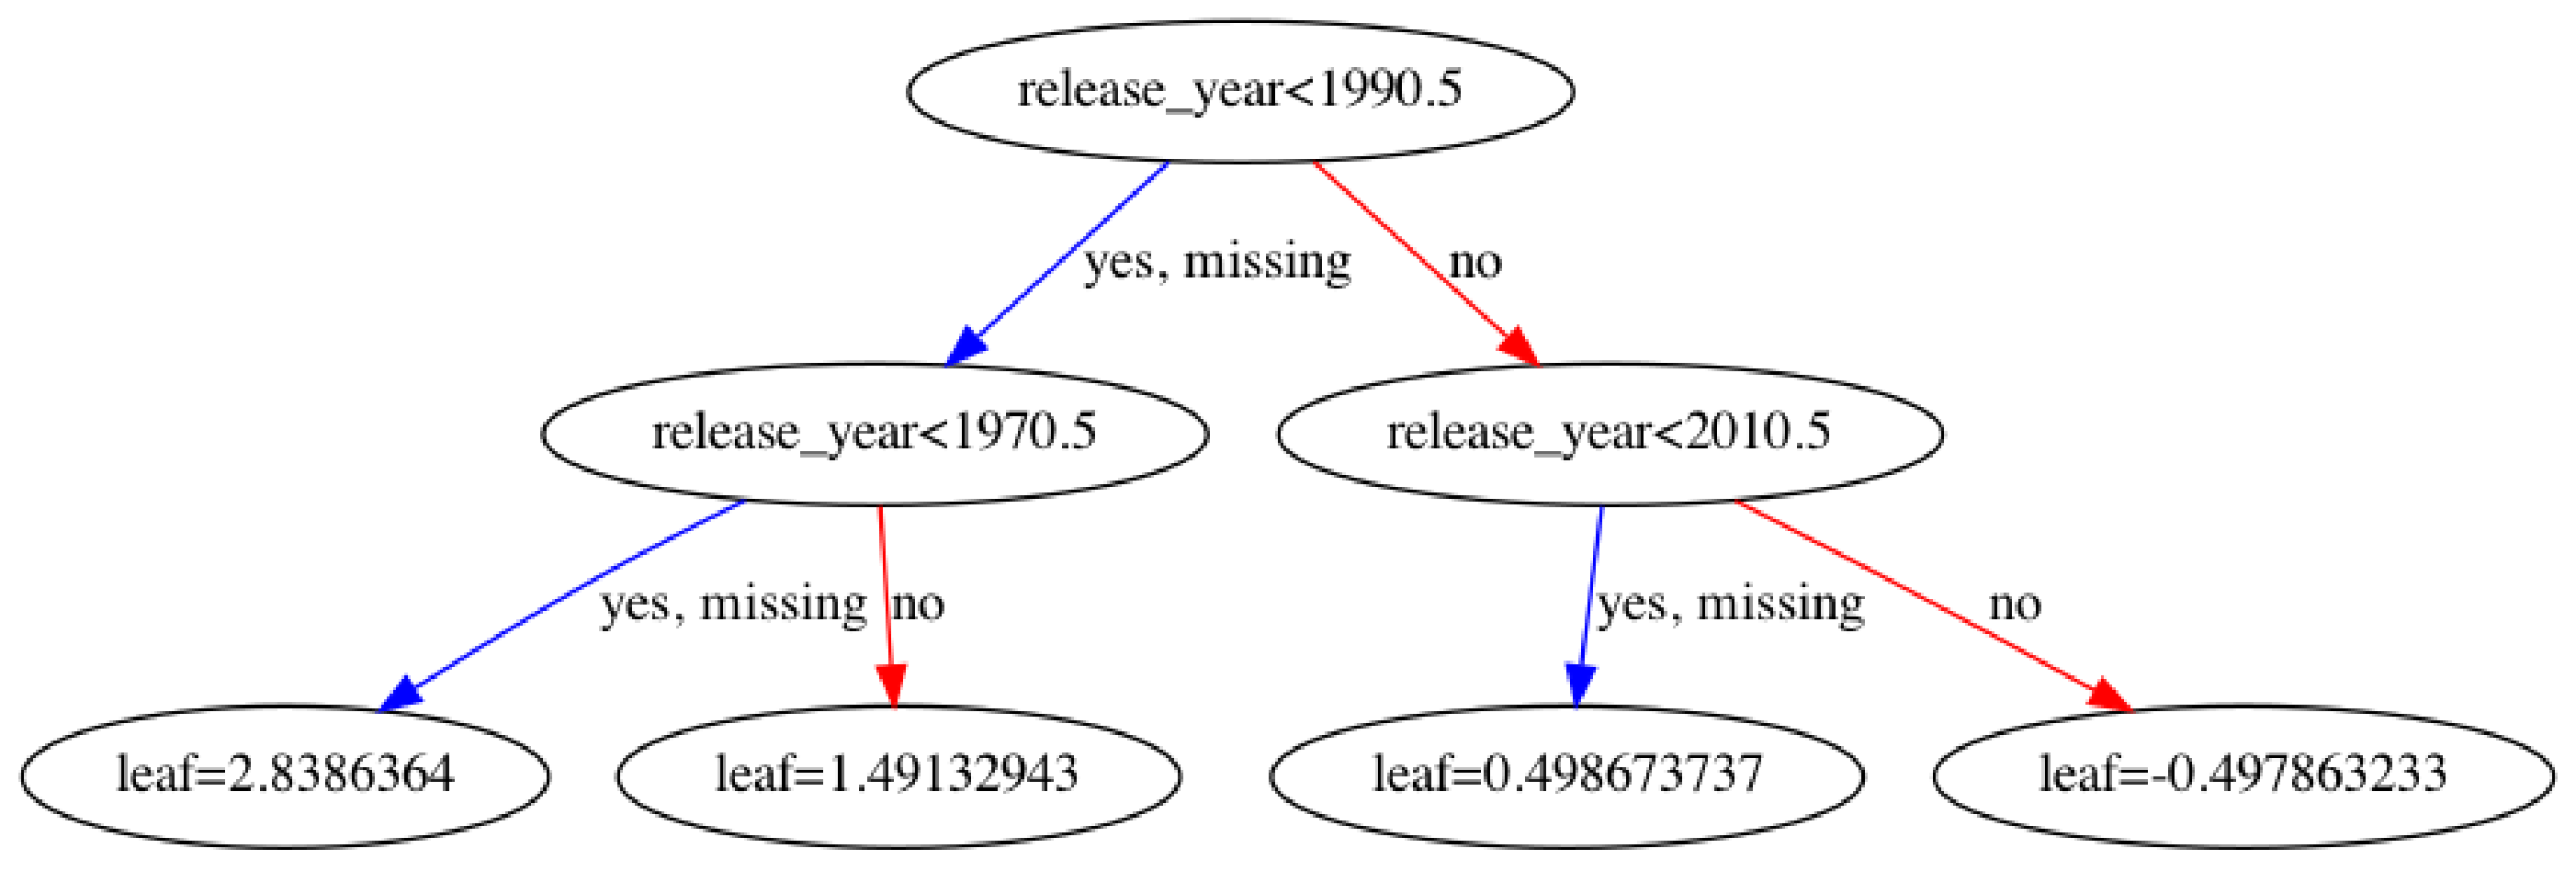

In [34]:
xgb.plot_tree(model)

In [35]:
param2 = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'rank:pairwise'}
ranking_model = xgb.train(param2, dmx, num_round)

[11:07:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [36]:
ranking_model.trees_to_dataframe()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,release_year,1990.5,0-1,0-2,0-1,449.257538,1000.000000,NaN
1,0,1,0-1,release_year,1959.5,0-3,0-4,0-3,8.596741,433.500000,NaN
2,0,2,0-2,release_year,2010.5,0-5,0-6,0-5,68.786743,566.500000,NaN
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,0.960784,152.000000,NaN
4,0,4,0-4,Leaf,NaN,NaN,NaN,NaN,0.656637,281.500000,NaN
5,0,5,0-5,Leaf,NaN,NaN,NaN,NaN,-0.288956,329.500000,NaN
6,0,6,0-6,Leaf,NaN,NaN,NaN,NaN,-0.995798,237.000000,NaN
7,1,0,1-0,release_year,1989.5,1-1,1-2,1-1,111.142654,762.361877,NaN
8,1,1,1-1,release_year,1971.5,1-3,1-4,1-3,14.943893,317.568207,NaN
9,1,2,1-2,release_year,2010.5,1-5,1-6,1-5,35.721516,444.793640,NaN


<AxesSubplot:>

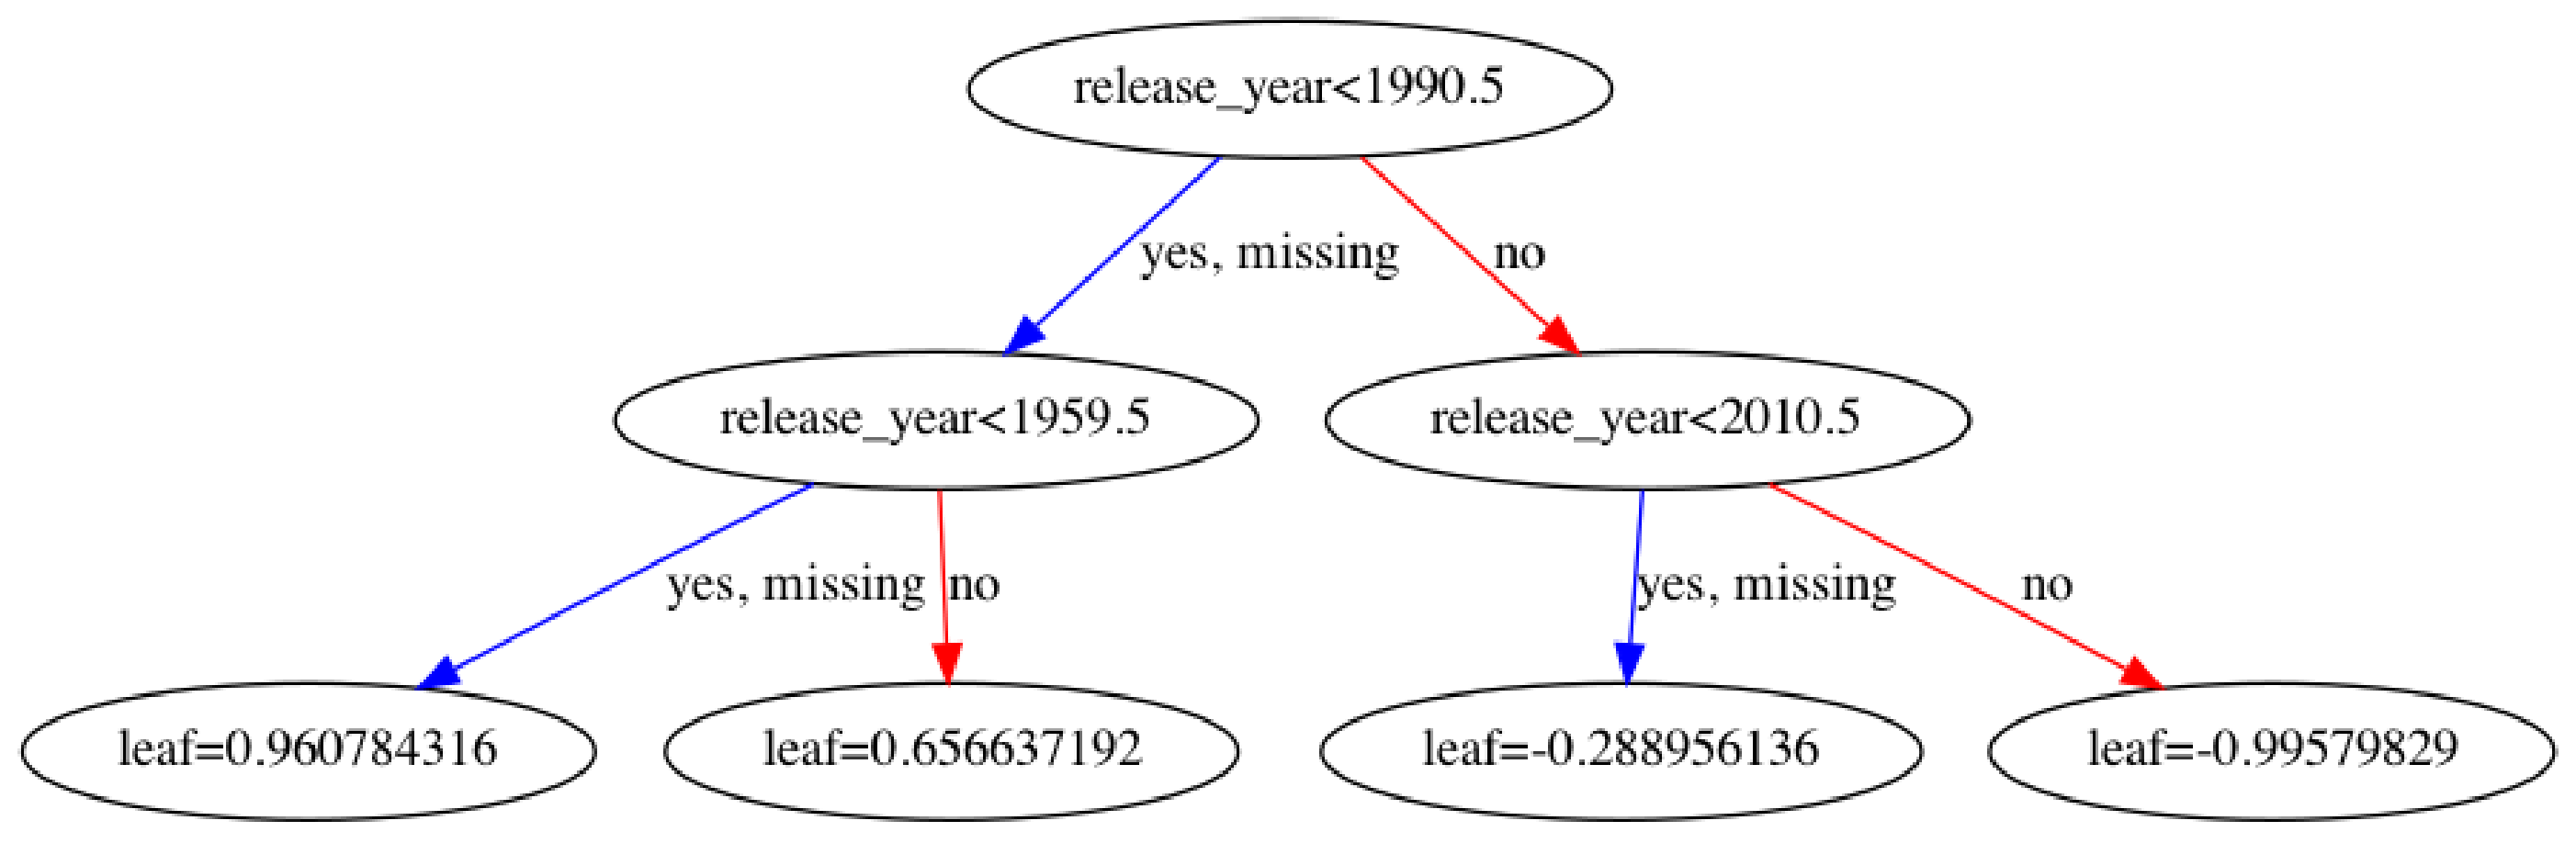

In [37]:
xgb.plot_tree(ranking_model)

In [38]:
model_dump = ranking_model.get_dump(fmap='fmap.txt', dump_format='json')

In [39]:
import json
clean_model = []
for line in model_dump:
    clean_model.append(json.loads(line))

In [40]:
client.submit_xgboost_model('release', 'tmdb', 'xgb', clean_model)

Delete model xgb: 404
Created Model xgb [Status: 201]


In [41]:
def search(client, user_query, model_name):
    engine_query = {
        "bool": {
            "must": {"match_all": {} },
            "filter": {
                "match": {"title": user_query}
            }
        }
    }
    return client.model_query('tmdb', model_name, {}, engine_query)

In [42]:
search(client, 'batman', 'xgb')

/Users/hiromu.nakamura/ghq/github.com/po3rin/python_playground/.venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.16/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


[{'id': '93560',
  'title': 'Batman and Robin',
  'overview': 'This 15-chapter serial pits Batman and Robin against The Wizard, who uses a device that allows him to control machinery to hold the city hostage.',
  'tagline': '',
  'directors': ['Spencer Gordon Bennet'],
  'cast': 'Robert Lowery Johnny Duncan Lyle Talbot Jane Adams Ralph Graves Don C. Harvey William Fawcett Leonard Penn Rick Vallin Michael Whalen Greg McClure House Peters Jr.',
  'genres': ['Action', 'Science Fiction', 'Thriller'],
  'release_date': '1949-05-26',
  'release_year': '1949',
  'poster_path': 'https://image.tmdb.org/t/p/w185/mhlVDSkxiyVqHBK8bqwfgK2v3e.jpg',
  'vote_average': 6.2,
  'vote_count': 5,
  'score': 2.5932665},
 {'id': '125249',
  'title': 'Batman',
  'overview': "Japanese spymaster Prince Daka operates a covert espionage organization located in Metropolis' now-deserted Little Tokyo which turns American scientists into pliable zombies.",
  'tagline': 'A HUNDRED TIMES MORE THRILLING ON THE SCREEN!',